Distillation Enviornment

In [ ]:
!pip install tensorflow
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install gekko

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
import numpy as np
import tensorflow as tf
import random
from gekko import GEKKO
import matplotlib.pyplot as plt

In [ ]:
#setup equations for the distillation tower
# Initialize Model
m = GEKKO()

# Define constants
#Reflux Ratio
rr=m.Param(value=4)
# Feed flowrate (mol/min)
Feed=m.Const(value=3)
# Mole fraction of feed
x_Feed=m.Const(value=.5)
#Relative volatility = (yA/xA)/(yB/xB) = KA/KB = alpha(A,B)
vol=m.Const(value=1.6)
# Total molar holdup on each tray
atray=m.Const(value=.25)
# Total molar holdup in condenser
acond=m.Const(value=.5)
# Total molar holdup in reboiler
areb=m.Const(value=.1)
# mole fraction of component A
x=[]
for i in range(32):
    x.append(m.Var(.3))
# Define intermediates
# Distillate flowrate (mol/min)
D=m.Intermediate(.5*Feed)
# Liquid flowrate in rectification section (mol/min)
L=m.Intermediate(rr*D)
# Vapor Flowrate in column (mol/min)
V=m.Intermediate(L+D)
# Liquid flowrate in stripping section (mol/min)
FL=m.Intermediate(Feed+L)
# vapor mole fraction of Component A
# From the equilibrium assumption and mole balances

y=[]
for i in range(32):
    y.append(m.Intermediate(x[i]*vol/(1+(vol-1)*x[i])))
# condenser
m.Equation(acond*x[0].dt()==V*(y[1]-x[0]))
# 15 column stages
n=1
for i in range(15):
    m.Equation(atray * x[n].dt() ==L*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1
# feed tray
m.Equation(atray * x[16].dt() == Feed*x_Feed + L*x[15] - FL*x[16] - V*(y[16]-y[17]))
# 14 column stages
n=17
for i in range(14):
    m.Equation(atray * x[n].dt() == FL*(x[n-1]-x[n]) - V*(y[n]-y[n+1]))
    n=n+1
# reboiler
m.Equation(areb  * x[31].dt() == FL*x[30] - (Feed-D)*x[31] - V*y[31])
# steady state solution

In [ ]:
# switch to dynamic simulation
m.options.imode=4
#set simulation and sampling time
nt = 101
m.time=np.linspace(0,100,101)

Distillation Tower Enviornment setup

In [ ]:
#D=np.arange(0, 10, .01)
D= MultiDiscrete(np.array([20, 10, 10, 10, 100]))
simlen = 1

class DistilEnv(Env):
    def __init__(self):
        # Actions
        self.action_space = D
        # observation space
        #self.observation_space = Box(low=np.array([0.0]), high=np.array([1.0]))
        #self.observation_shape = 101
        self.observation_space = Box(low = np.zeros(101), high = np.ones(101), dtype = np.float16)
        # Set start temp
        self.state = np.zeros(101)
        # Set simulation length
        self.simulation_length = simlen
        self.step = 0

    def step(self, action):

        # Reduce  length by 1 second
        self.step +=1
        self.simulation_length -= 1
        # Apply action:
        t_r= action[0]
        t_f= action[1]
        ss = t_r+t_f

        val_tr = action[2]
        val_tf = action[3]
        val_ss = action[4]/10

        #Simulate
        rr_step = np.ones(nt)
        rr_step[:t_r] = val_tr
        rr_step[t_r:t_r+t_f] = val_tf
        rr_step[ss:] = val_ss
        rr.value=rr_step
        m.solve(disp=False, debug=False)
        # Calculate reward
        self.state = y[1]
        reward=0
        if self.simulation_length == simlen:
          score=0
        for i in range(101):
          if self.state[i] > 0.96 and self.state[i] <= 0.98:
              rew = 1
              reward += rew
          if self.state[i] == 0.97:
              rew = 10
              reward += rew
          else:
              rew = 0
              reward += rew

        print('sim:{} step:{} reward:{}  tr {} tf {} ss {} {} {} {}'.format(self.simulation_length +1,self.step, reward, t_r, t_f, ss,val_tr, val_tf, val_ss ))
        # Check if simulation is done
        if self.simulation_length <= 0:
            done = True
        else:
            done = False

        # Apply feed rate noise
        #self.state += random.randint(-0.3,0.3)
        # Set placeholder for info
        info = {}

        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass

    def reset(self):
        # Reset state
        self.state = y[1]
        score= 0
        self.step = 0
        # Reset shower time
        self.simulation_length = simlen
        return self.state


env = DistilEnv()

C:\Program Files\Python311\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Test Enviornment

In [ ]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample().tolist()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('\n \n \n Episode:{} Score:{} \n \n \n'.format(episode, score))


sim:1 reward:0  tr 1 tf 2 ss 3 1 1 2.4

 
 
 Episode:1 Score:0 
 
 



In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

A2C Reinforcement Learning

In [ ]:
from stable_baselines3 import A2C

Load model

In [ ]:
model_path = "Users\pc\Desktop\model\model1.zip"
model=A2C.load(model_path, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
import os
logdir = "Users\pc\Desktop\model\logs"

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [ ]:
TIMESTEPS=10000
#model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=logdir)
#continue learning
model=A2C.load(model_path, env=env,verbose=1, tensorboard_log=logdir )
model.learn(total_timesteps = TIMESTEPS, reset_num_timesteps=False, tb_log_name="A2C")

can view outcome using terminal and tensorboard --logdir=logs

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6
sim:1 reward:97  tr 1 tf 1 ss 2 6 7 3.6


In [ ]:
score = 0
episodes = 1
for ep in range(episodes):
	obs = env.reset()
	done = False
	while not done:
		# pass observation to model to get predicted action
		action, _states = model.predict(obs)

		# pass action to env and get info back
		state, reward, done, info = env.step(action)
		score+=reward
		print('\n \n \n Episode:{} Score:{} \n \n \n'.format(episode, score))


sim:1 reward:82  tr 1 tf 5 ss 6 4 5 3.6

 
 
 Episode:1 Score:82 
 
 



In [ ]:
models_dir = "Users\pc\Desktop\model"
#change for new model
num=120
model.save(f"{models_dir}/{num*i}")

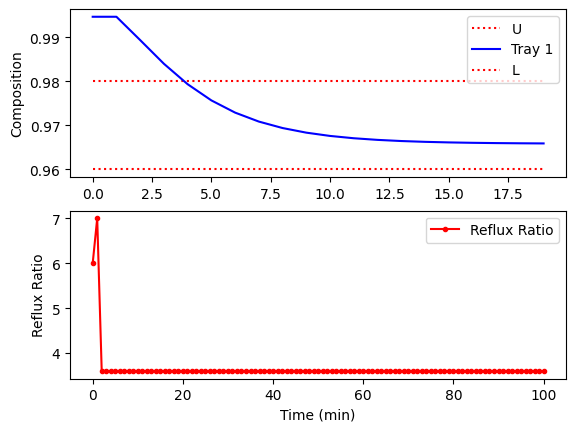

In [ ]:
up_limit= np.ones(20)*0.98
low_limit= np.ones(20)*0.96
plt.subplot(2,1,1)
plt.plot(m.time[0:20], up_limit,'r:',label='U')
plt.plot(m.time[0:20],y[1][0:20],'b-',label='Tray 1')
plt.plot(m.time[0:20], low_limit,'r:',label='L')

plt.ylabel('Composition')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(m.time,rr.value,'r.-',label='Reflux Ratio')
plt.ylabel('Reflux Ratio')
plt.legend(loc='best')

plt.xlabel('Time (min)')
plt.show()

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.





















. . . . . . . . . . . . . . . .

. . . . . . . . . . . . . . . .

. . . . . . . . . . . . . . . .

. . . . . . . . . . . . . . . .

DQN deep reinfrcement learning algorithm

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
#env.observation_space=np.array(env.observation_space)
states = env.observation_space.shape
actions = env.action_space.nvec.shape
#actions = Discrete(6).n

In [ ]:
env.action_space.nvec

array([ 20,  10,  10,  10, 100], dtype=int64)

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model

In [ ]:
model = build_model(states, actions)
model.summary()

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=5000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=5, visualize=False, verbose=1)

In [ ]:
scores = dqn.test(env, nb_episodes=1, visualize=False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
plt.subplot(2,1,1)
plt.plot(m.time,y[1].value,'b:',label='Tray 1')
plt.ylabel('Composition')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(m.time,rr.value,'r.-',label='Reflux Ratio')
plt.ylabel('Reflux Ratio')
plt.legend(loc='best')

plt.xlabel('Time (min)')
plt.show()

save model

In [ ]:
dqn.save_weights('dqn_Dist_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = DistilEnv()
actions = env.action_space.n
states = env.observation_space.shape
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')
_ = dqn.test(env, nb_episodes=5, visualize=False)

useful script

In [ ]:
# rr_step = np.ones(nt) * 0.7
# rr_step[:t_r] = val_tr
# rr_step[t_r:t_r+t_f] = val_tf
# rr_step[ss:] = val_ss
# rr.value=rr_step
# rr.value
# #m.solve()

In [ ]:
# action=env.action_space.sample().tolist()
# t_r= action[0][0]
# t_f= action[0][1]
# ss = t_r+t_f
# val_tr = action[1][0]
# val_tf = action[1][1]
# val_ss = action[1][2]/10

# print('tr:{} tf:{} ss:{}   {} {} {}'.format(t_r, t_f,ss,val_tr,val_tf,val_ss))